# End-to-End Machine Learning Project

### Main steps:
- Look at the big picture
- Get the data
- Discover and visualize the data to gain insights
- Prepare the data for machine learning algorithms
- Select a model and train it
- Fine tune the model
- Present the solution
- Launch, monitor, and maintain your system

### Task: to build a model of housing prices in California using the California census data

Your model should learn from this data and be able to predict the median housing price in any distrct, given all the other metrics.

### Frame the Problem

Building a model is probably not the end goal. How does the company expect to use and benefit from this model? This is importante, because it determines:
- how you frame the problem
- what algorithm to use
- what performance measure to use
- how much effort you should spend

Turns out, the model's output will be fed to another machine learning system, along with many other signals. This downstream system will determine whether it is worth investing in a given area or not.

One questions to ask: What the current solution looks like(if any). It will often give you a reference performance, and some insights on how to solve the problem.

This task has been done by experts mannualy, and the results have not been so good(typical error rate is about 15%)

**This is a supervised, regression, batch learning task**

### Select a Performance Measure

RMSE is a typical measure for regression tasks, but it is too sensitive to outliers, in this case, mean absolute error would be better.

### Download the Data

In [1]:
import numpy as np
import pandas as pd

In [2]:
housing = pd.read_csv('./datasets/housing/housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Notice that there are some missing values in the attribute total_bedrooms

In [4]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Note that the null values are ignored

In [6]:
import matplotlib.pyplot as plt

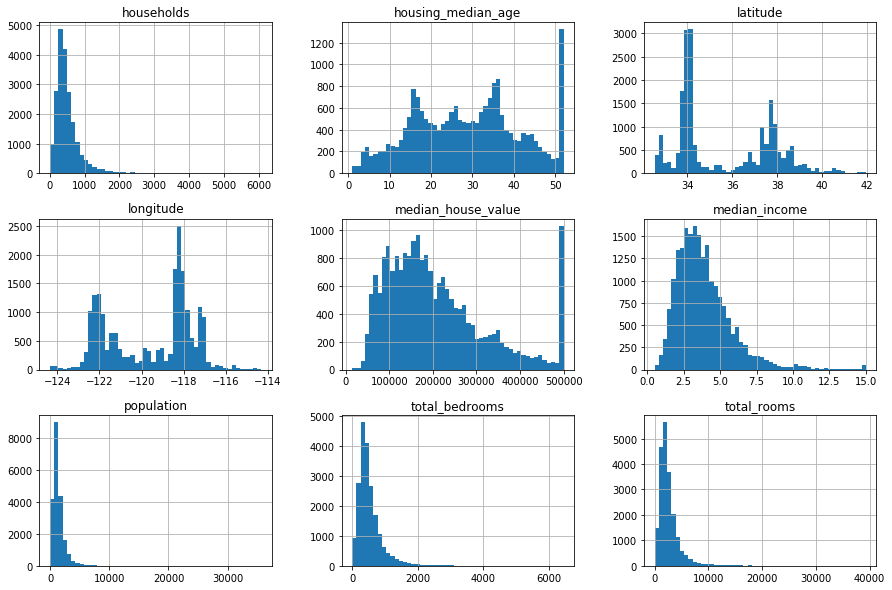

In [7]:
housing.hist(bins=50, figsize=(15, 10))
plt.show()

Notice a few things:
- the median income is not in dollars, but has been scaled, it is common to work with scaled data, but trying to understand how the data is computed is important
- the housing_median_age and median_house_value seems to have been capped, this is not good, because your algorithm might learn that the target(median_house_value) will never go higher than 500000.
- two options to deal with the capped median_house_value: recollect correct data for the capped instances;remove those instance from the training and testing set
- the attributes have very different scales, sth needs to be done to fix it
- many attributes are *tail heavy*, which will make it hard for some ml algorithms to detect parttens, need to be transformed into more *bell-shaped* distributions

**Before you look at the data any further, you need to create a test set, put it aside, and never look at it.**

Your brain is an amazing pattern detection system, which means that it is highly prone to overfitting: if you look at the test set, you may stumble upon some seemingly interesting pattern in the test set that leads you to choose a particular kind of ml model. When you estimate the generalization error using the test set, your estimate will be too optimistic and you will launch a system that will not perform as well as expected. This is called *data snooping* bias.

### Create a Test Set

In [8]:
# simple random sample
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

print('Number of all instances: {}'.format(housing.shape[0]))
print('Number of training samples: {}'.format(train_set.shape[0]))
print('NUmber of test samples: {}'.format(test_set.shape[0]))

Number of all instances: 20640
Number of training samples: 16512
NUmber of test samples: 4128


In [9]:
# stratified sampling on certain attribute
housing['income_cat'] = np.ceil(housing.median_income / 1.5)
housing['income_cat'] = housing.income_cat.where(housing.income_cat < 5, 5.0)

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing.income_cat):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

print('income distribution in all dataset: \n{}'.format(housing.income_cat.value_counts(normalize=True)))
print('income distribution in train set: \n{}'.format(strat_train_set.income_cat.value_counts(normalize=True)))
print('income distribution in test set: \n{}'.format(strat_test_set.income_cat.value_counts(normalize=True)))

strat_train_set = strat_train_set.drop('income_cat', axis=1)
strat_test_set = strat_test_set.drop('income_cat', axis=1)

income distribution in all dataset: 
3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64
income distribution in train set: 
3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64
income distribution in test set: 
3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64


In [10]:
housing.shape, strat_train_set.shape, strat_test_set.shape

((20640, 11), (16512, 10), (4128, 10))

### Discover and Visualize the Data to Gain insights

**First, make sure that you have put the test set aside and only exploring the training set**

If the training set is too large, you may want to resample it for quick visualization. However, our dataset here is pretty small.

In [11]:
# Make a copy of the training data for visualization
housing = strat_train_set.copy()

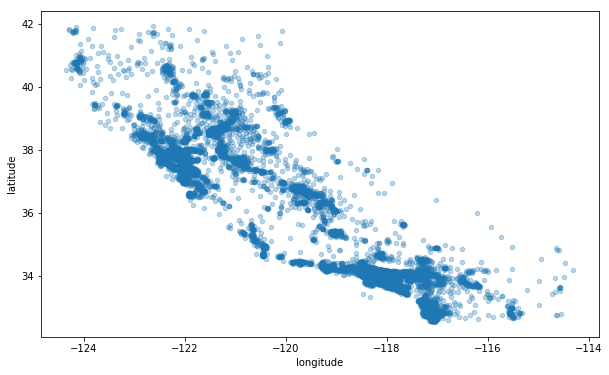

In [12]:
# scatter plot the latitude and longitude to visualize the geographical information
housing.plot(kind='scatter', x='longitude', y='latitude', figsize=(10,  6), alpha=0.3)

Now we can clearly see the high-density areas, namely the Bay Area and around Los Angeles and San Diego and so on.

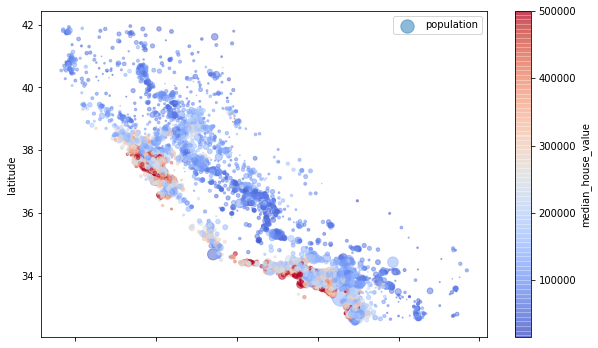

In [13]:
# add more infomation to the plot
housing.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    s=housing.population/100,
    label='population',
    alpha=0.5,
    figsize=(10, 6),
    c='median_house_value',
    cmap='coolwarm'
)
plt.legend()
plt.show()

- the prices are very much related to the location and the population density
- clustering them into clusters and add a distance to cluster center feature might help
- ocean proximity might be helpful

### Looking for Correlations

In [14]:
corr_matrix = housing.corr()

In [15]:
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

**Note: correlation being zero just means no linear correlation, but not no relation between the variables**

**Note: the magnitude of correlation has nothing to do with the slope, just tells how well are they linearly correlated**

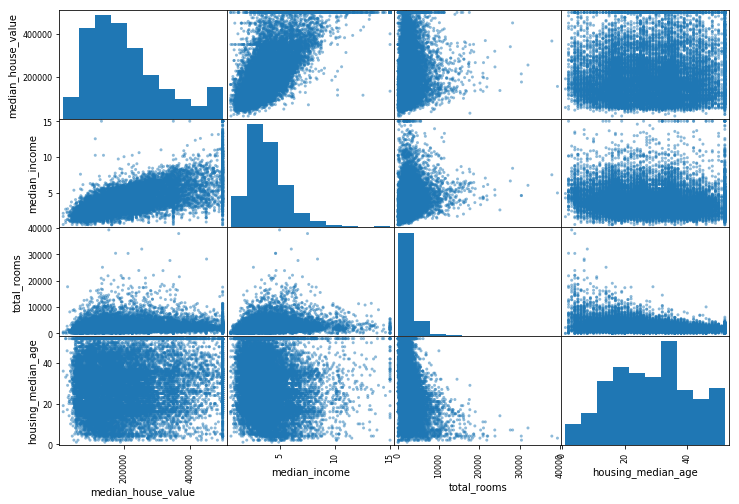

In [16]:
# Use scatter_matrix to see the correlations
attris = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
pd.plotting.scatter_matrix(housing[attris], figsize=(12, 8))
plt.show()

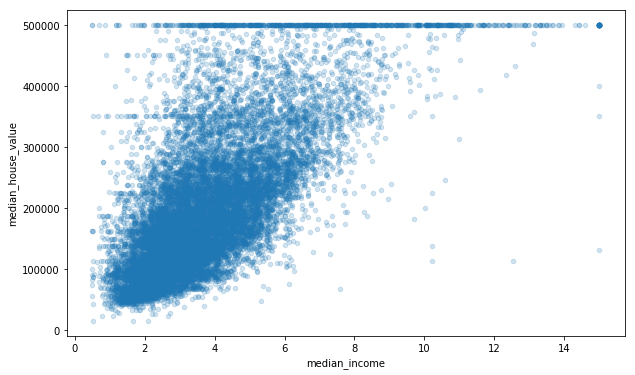

In [17]:
# zoom in to the seemingly most promising feture:
housing.plot(kind='scatter', x='median_income', y='median_house_value', figsize=(10, 6), alpha=0.2)
plt.show()

- very strong linear correlation
- several horizontal lines can be observed, due to capped samples, we might need to remove them to prevent the model learn this unreal pattern

### Experimenting with attribute combinations

One last thing you may want to do before preparing the data for ml algorithms is to try out various attributes combinations.

The total number of rooms in a district is not very useful if we don't know how many households are. Similarly, the total bedroom by itself is not very useful, neither.

In [18]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [19]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

the new feature rooms_per_household seems useful!

**This round of exploration does not have to be absolutely thorough; the point is to start off on the right foot and quickly gain insights that will help you get a reasonably good prototype. But this is a iterative process: once you get a prototype up and running, you can analyse its output to gain more insights and come back to this exploration step**

### Prepare the Data for ML algorithms

You should write functions to do this instead of doing it manually:
- This will allow you to reproduce these transformations easily on any dataset
- You will gradually build a library of transformation functions that you can reuse in future projects
- You can use these functions in your live system to transform the new data before feeding it to your algorithms
- This will make it possible for you to easily try various transformations and see which combination of transformation works best

In [21]:
# seperate the data and the label
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value']

#### Data cleaning

In [23]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

In [24]:
# create a copy of the data that only contains numeric features
housing_num = housing.drop('ocean_proximity', axis=1)

In [25]:
imputer.fit(housing_num)
print('imputer.statistics: \n{}'.format(imputer.statistics_))
print('median values: \n{}'.format(housing_num.median().values))

imputer.statistics: 
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
median values: 
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


In [26]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [27]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


#### Handling text and categorocal attributes

In [28]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)
print('encoder.classes_: \n{}'.format(encoder.classes_))

encoder.classes_: 
['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [32]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat[:, np.newaxis])
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [33]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [35]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

#### Custom Transformers